#Explainer File

In [ ]:
!gdown 1UlskjfSuMXq4Zxb1vxjBr1EKh2lhfrHJ

Downloading...
From: https://drive.google.com/uc?id=1UlskjfSuMXq4Zxb1vxjBr1EKh2lhfrHJ
To: /content/embedding_train_explainer.md
100% 2.52k/2.52k [00:00<00:00, 12.9MB/s]


#Import Libraries And Data

##Libraries

In [ ]:
%%capture
import kagglehub
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
!pip install ipython-autotime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from collections import Counter
from tensorflow.keras import layers, models, regularizers
%load_ext autotime

time: 325 µs (started: 2025-04-14 10:35:00 +00:00)


##Data

In [ ]:
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
!mkdir /content/dataset
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset
!mv /kaggle/input/stanford-cars-dataset/* /content/dataset

Streaming output truncated to the last 5000 lines.
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/05728.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/05599.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/01116.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/03807.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/04438.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/07455.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/06060.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_train/cars_train/06052.jpg': Read-only file system
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_t

In [ ]:
!gdown 1DuxsPDp4Dz-iBYZXj6xbL0f6iU9ZbIa2 -O stanford_cars_with_class_names_training.csv
!gdown 1lD1pcg7ddqo-qxGZhW6XKYJAwAbuzuPE -O stanford_cars_with_class_names_test.csv

Downloading...
From: https://drive.google.com/uc?id=1DuxsPDp4Dz-iBYZXj6xbL0f6iU9ZbIa2
To: /content/stanford_cars_with_class_names_training.csv
100% 502k/502k [00:00<00:00, 146MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lD1pcg7ddqo-qxGZhW6XKYJAwAbuzuPE
To: /content/stanford_cars_with_class_names_test.csv
100% 472k/472k [00:00<00:00, 124MB/s]
time: 8.13 s (started: 2025-04-14 10:37:13 +00:00)


Load CSV files content

In [ ]:
import pandas as pd

def load_and_inspect_csv(file_path):
    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df.columns = df.columns.str.strip()
        df.rename(columns={'ture_class_name': 'true_class_name'}, inplace=True)

        print("CSV Data Preview:")
        print(df.head())

        print("\nColumn Names:", df.columns)
        print("\nData Info:")
        print(df.info())

        return df
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return None

csv_train_file_path = '/content/stanford_cars_with_class_names_training.csv'
csv_test_file_path = '/content/stanford_cars_with_class_names_test.csv'

data_cleaned_train = load_and_inspect_csv(csv_train_file_path)
data_cleaned_test = load_and_inspect_csv(csv_test_file_path)
data_cleaned_test["image"] = data_cleaned_test["image"].str.strip().str.replace("'", "")



CSV Data Preview:
   Unnamed: 0   x1   y1    x2    y2  class  \
0           0   39  116   569   375     14   
1           1   36  116   868   587      3   
2           2   85  109   601   381     91   
3           3  621  393  1484  1096    134   
4           4   14   36   133    99    106   

                       true_class_name      image  
0                  Audi TTS Coupe 2012  00001.jpg  
1                  Acura TL Sedan 2012  00002.jpg  
2           Dodge Dakota Club Cab 2007  00003.jpg  
3     Hyundai Sonata Hybrid Sedan 2012  00004.jpg  
4  Ford F-450 Super Duty Crew Cab 2012  00005.jpg  

Column Names: Index(['Unnamed: 0', 'x1', 'y1', 'x2', 'y2', 'class', 'true_class_name',
       'image'],
      dtype='object')

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       8144 non-null   int64 
 1   x1      

#Data Processing

###Preprocessing

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
csv_train = "/content/stanford_cars_with_class_names_training.csv"
csv_test = "/content/stanford_cars_with_class_names_test.csv"

dir_train = "/content/dataset/cars_train/cars_train"
dir_test = "/content/dataset/cars_test/cars_test"

save_img_path = "/content/all_images.npy"
save_label_path = "/content/all_labels.npy"

df_train = pd.read_csv(csv_train, encoding="utf-8-sig")
df_test = pd.read_csv(csv_test, encoding="utf-8-sig")

for df in [df_train, df_test]:
    df.columns = df.columns.str.strip()
    df["image"] = df["image"].str.strip().str.replace("'", "")
    df.rename(columns={"ture_class_name": "true_class_name"}, inplace=True)
    df["class"] = df["class"] - 1

df_train["path"] = df_train["image"].apply(lambda x: os.path.join(dir_train, x))
df_test["path"] = df_test["image"].apply(lambda x: os.path.join(dir_test, x))

df_all = pd.concat([df_train, df_test], ignore_index=True)

resize_to = (320, 180)

images = np.zeros((len(df_all), resize_to[1], resize_to[0], 3), dtype=np.uint8)
labels = np.zeros(len(df_all), dtype=np.int32)

for i, row in tqdm(df_all.iterrows(), total=len(df_all)):
    try:
        with Image.open(row["path"]) as img:
            x1, y1, x2, y2 = map(int, [row["x1"], row["y1"], row["x2"], row["y2"]])
            cropped = img.crop((x1, y1, x2, y2)).convert("RGB")

            img_tensor = tf.convert_to_tensor(np.array(cropped), dtype=tf.uint8)
            padded_resized = tf.image.resize_with_pad(img_tensor, target_height=resize_to[1], target_width=resize_to[0])
            padded_resized = tf.cast(padded_resized, tf.uint8).numpy()

            images[i] = padded_resized
            labels[i] = row["class"]
    except Exception as e:
        print(f"Error processing {row['path']}: {e}")

np.save(save_img_path, images)
np.save(save_label_path, labels)

print(f"✅ Saved all images: {save_img_path}, shape: {images.shape}")
print(f"✅ Saved all labels: {save_label_path}, shape: {labels.shape}")


100%|██████████| 16185/16185 [03:25<00:00, 78.79it/s]


✅ Saved all images: /content/all_images.npy, shape: (16185, 180, 320, 3)
✅ Saved all labels: /content/all_labels.npy, shape: (16185,)
time: 3min 29s (started: 2025-04-14 10:37:22 +00:00)


###Split Data

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

images = np.load(save_img_path)
labels = np.load(save_label_path)

images = images.astype("float32") / 255.0
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=196)

X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)


time: 9.83 s (started: 2025-04-14 10:40:51 +00:00)


###Labels For Test

In [ ]:
y_test_int = np.argmax(y_test, axis=1) + 1
y_train_int = np.argmax(y_train, axis=1) + 1

time: 3.07 ms (started: 2025-04-14 10:41:01 +00:00)


##Augmentation Pipeline

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.central_crop(image, central_fraction=tf.random.uniform([], 0.8, 1.0))
    image = tf.image.resize(image, [180, 320])
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

def build_dataset(X, y, batch_size=32, shuffle=True, augment_data=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(1000)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = build_dataset(X_train, y_train, augment_data=True)
val_dataset = build_dataset(X_test, y_test, shuffle=False, augment_data=False)


time: 16.5 s (started: 2025-04-14 10:41:01 +00:00)


#Models

##Generic Functions

In [ ]:
def build_training_model(embedding_model, num_classes=196):
    x = embedding_model.output
    classifier_output = layers.Dense(num_classes, activation="softmax", name="classifier")(x)
    return models.Model(inputs=embedding_model.input, outputs=classifier_output)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

def show_loss(history):
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
  plt.plot(history.history['loss'], label='Training Loss', color='blue')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training vs. Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

time: 725 µs (started: 2025-04-14 10:41:17 +00:00)


##KNN Generic Functions

In [ ]:
def find_nearest_neighbors(knn, model, query_image, y_test_label, X_train, y_train_labels):
    embedding = model.predict(np.expand_dims(query_image, axis=0), verbose=0)

    distances, indices = knn.kneighbors(embedding, return_distance=True)
    indices = indices[0]
    distances = distances[0]

    nearest_labels = [y_train_labels[i] for i in indices]
    most_common_label = Counter(nearest_labels).most_common(1)[0][0]

    num_neighbors = len(indices)
    num_cols = 5
    num_rows = (num_neighbors + 1) // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    axes[0].imshow(query_image)
    axes[0].set_title(f"Query Image\nTrue Label: {y_test_label}")
    axes[0].axis("off")

    for i, idx in enumerate(indices):
        axes[i + 1].imshow(X_train[idx])
        axes[i + 1].set_title(f"Label: {y_train_labels[idx]}")
        axes[i + 1].axis("off")

    for j in range(i + 2, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    return nearest_labels, distances, most_common_label

def get_embeddings(model, images, batch_size=64):
   return model.predict(images, batch_size=batch_size)

time: 939 µs (started: 2025-04-14 10:41:17 +00:00)


##Resnet Model 1

###Architecture

In [ ]:
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation="relu"):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation(activation)(x)

    return x

def create_resnet_model(input_shape=(180, 320, 3), embedding_dim=1024):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    for filters in [64, 128, 256, 512]:
        for _ in range(3):
            x = residual_block(x, filters)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation="relu")(x)

    embedding = layers.Dense(embedding_dim, activation="linear", name="embedding")(x)

    model = models.Model(inputs, embedding, name="resnet_embedding_model")
    return model

resnet_model = create_resnet_model()
resnet_model.summary()


Model: "resnet_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 160,   │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 160,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 160,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 80,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 80,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 45, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 80,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 45, 80,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 45, 80,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 45, 80,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 45, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 45, 80,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_4[0][0]  

 Total params: 42,638,336 (162.65 MB)

 Trainable params: 42,624,896 (162.60 MB)

 Non-trainable params: 13,440 (52.50 KB)

time: 1.15 s (started: 2025-04-14 10:41:17 +00:00)


###Train

In [ ]:
resnet_model_train = build_training_model(resnet_model, num_classes=196)

time: 13.4 ms (started: 2025-04-14 10:41:18 +00:00)


In [ ]:
 resnet_model_train.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_history = resnet_model_train.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=[early_stopping]
)

Epoch 1/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 77s 90ms/step - accuracy: 0.0079 - loss: 6.7539 - val_accuracy: 0.0059 - val_loss: 5.2914
Epoch 2/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0157 - loss: 5.1452 - val_accuracy: 0.0188 - val_loss: 5.0727
Epoch 3/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0289 - loss: 4.9757 - val_accuracy: 0.0346 - val_loss: 4.7745
Epoch 4/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0518 - loss: 4.6551 - val_accuracy: 0.0812 - val_loss: 4.2391
Epoch 5/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0966 - loss: 4.0746 - val_accuracy: 0.0856 - val_loss: 4.1155
Epoch 6/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.1766 - loss: 3.4498 - val_accuracy: 0.1492 - val_loss: 3.7079
Epoch 7/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.2714 - loss: 2.8286 - val_accuracy: 0.2181 - val_loss: 3.2063
Epoch 8/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.3837 - loss: 2

###Loss Graph

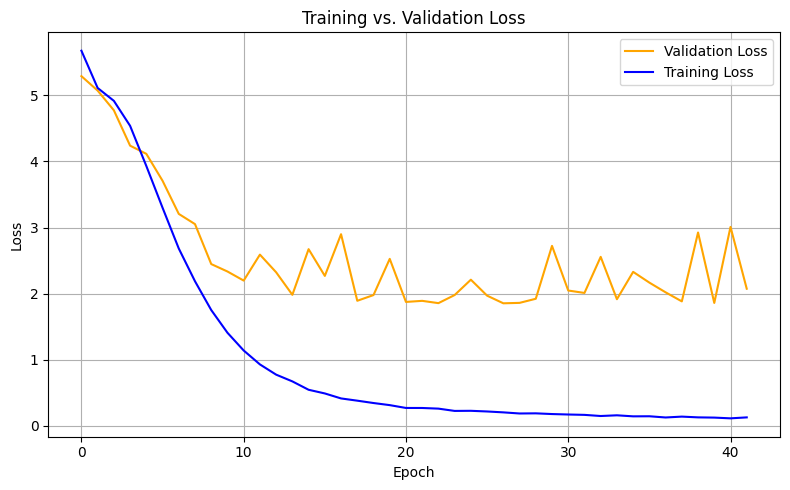

time: 180 ms (started: 2025-04-14 10:52:11 +00:00)


In [ ]:
show_loss(resnet_history)

###Test

####Get Embedding

In [ ]:
test_embeddings_resnet1 = get_embeddings(resnet_model, X_train)

203/203 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step
time: 19.4 s (started: 2025-04-14 10:52:11 +00:00)


####Define Model

In [ ]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(test_embeddings_resnet1, y_train_int)
preds = knn.predict(test_embeddings_resnet1)
acc = accuracy_score(y_train_int, preds)
print(f"KNN Accuracy: {acc:.4f}")

KNN Accuracy: 0.8937
time: 2.21 s (started: 2025-04-14 10:52:31 +00:00)


####Run Test

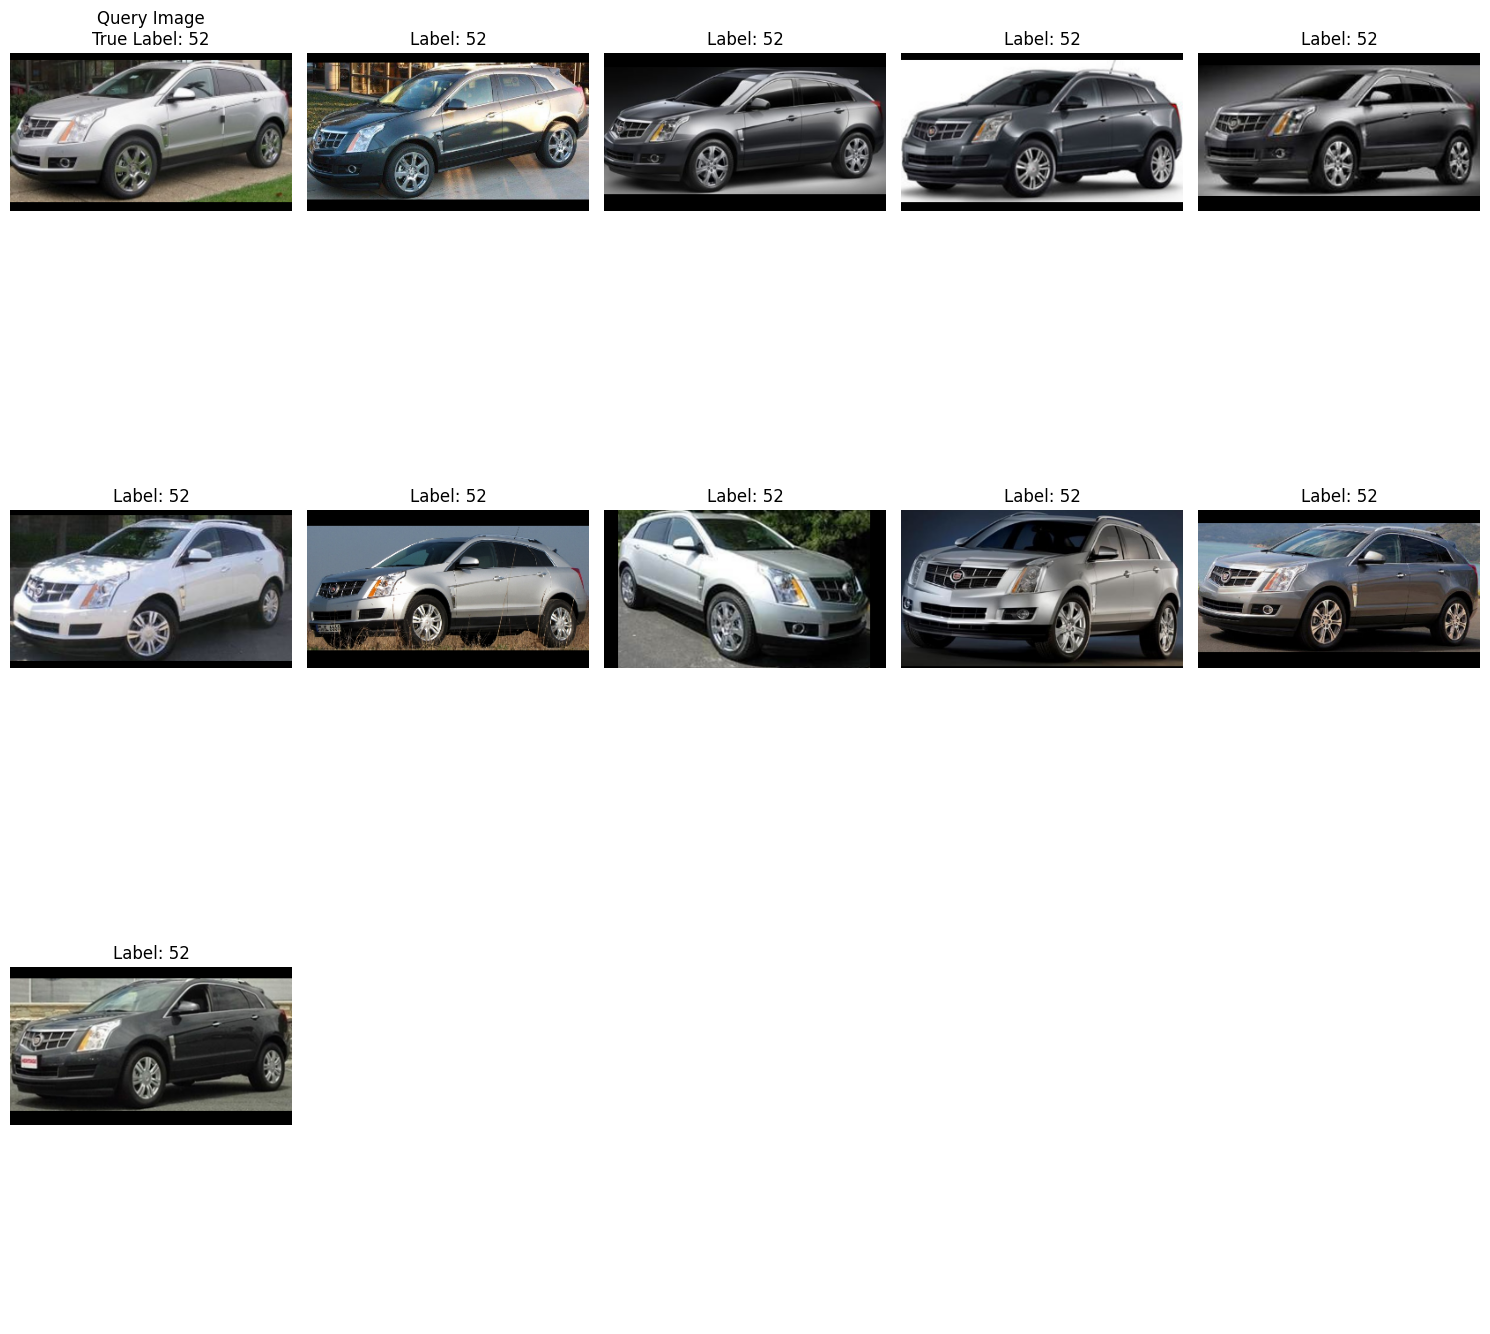

🎯 True label: 52
🔮 Predicted (most common): 52
👥 Nearest labels: [np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(52), np.int64(52)]
📏 Distances: [29.23168755 30.73742676 32.19038391 33.2453537  33.34012985 33.84697723
 34.03328323 34.2117157  34.88283539 34.88609695]
time: 2.06 s (started: 2025-04-14 10:52:33 +00:00)


In [ ]:
index = 777

nearest_labels, distances, predicted_label = find_nearest_neighbors(
    knn=knn,
    model=resnet_model,
    query_image=X_test[index],
    y_test_label=y_test_int[index],
    X_train=X_train,
    y_train_labels=y_train_int
)

print(f"🎯 True label: {y_test_int[index]}")
print(f"🔮 Predicted (most common): {predicted_label}")
print(f"👥 Nearest labels: {nearest_labels}")
print(f"📏 Distances: {distances}")

##Resnet Model 2 With L2

###Architecture

In [ ]:
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation="relu"):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation(activation)(x)

    return x

def create_resnet_l2_model(input_shape=(180, 320, 3), embedding_dim=256):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    for filters in [64, 128, 256, 512]:
        for _ in range(3):
            x = residual_block(x, filters)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(2048, activation="relu")(x)

    embedding = layers.Dense(embedding_dim, activation="linear", name="embedding")(x)

    embedding = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1), name="l2_normalized")(embedding)

    model = models.Model(inputs, embedding, name="resnet_l2_embedding_model")
    return model

resnet_model2 = create_resnet_l2_model()
resnet_model2.summary()


Model: "resnet_l2_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 90, 160,   │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        256 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 90, 160,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 45, 80,    │          0 │ activation_25[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 45, 80,    │     36,928 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 45, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 45, 80,    │     36,928 │ activation_26[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 45, 80,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 45, 80,    │          0 │ add_12[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 45, 80,    │     36,928 │ activation_27[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 45, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 45, 80,    │     36,928 │ activation_28[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_32[0][0] 

 Total params: 28,479,744 (108.64 MB)

 Trainable params: 28,466,304 (108.59 MB)

 Non-trainable params: 13,440 (52.50 KB)

time: 869 ms (started: 2025-04-14 10:52:35 +00:00)


###Train

In [ ]:
resnet_model2_train = build_training_model(resnet_model2, num_classes=196)

time: 17.6 ms (started: 2025-04-14 10:52:36 +00:00)


In [ ]:
 resnet_model2_train.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model2_history = resnet_model2_train.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=[early_stopping]
)

Epoch 1/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.0091 - loss: 5.2695 - val_accuracy: 0.0090 - val_loss: 5.2621
Epoch 2/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0140 - loss: 5.2169 - val_accuracy: 0.0145 - val_loss: 5.1874
Epoch 3/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0263 - loss: 5.1528 - val_accuracy: 0.0334 - val_loss: 5.0874
Epoch 4/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0488 - loss: 5.0540 - val_accuracy: 0.0142 - val_loss: 5.1680
Epoch 5/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0786 - loss: 4.9386 - val_accuracy: 0.0853 - val_loss: 4.8738
Epoch 6/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.1110 - loss: 4.8110 - val_accuracy: 0.1152 - val_loss: 4.7572
Epoch 7/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.1653 - loss: 4.6774 - val_accuracy: 0.1273 - val_loss: 4.6644
Epoch 8/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.2165 - loss: 4

###Loss Graph

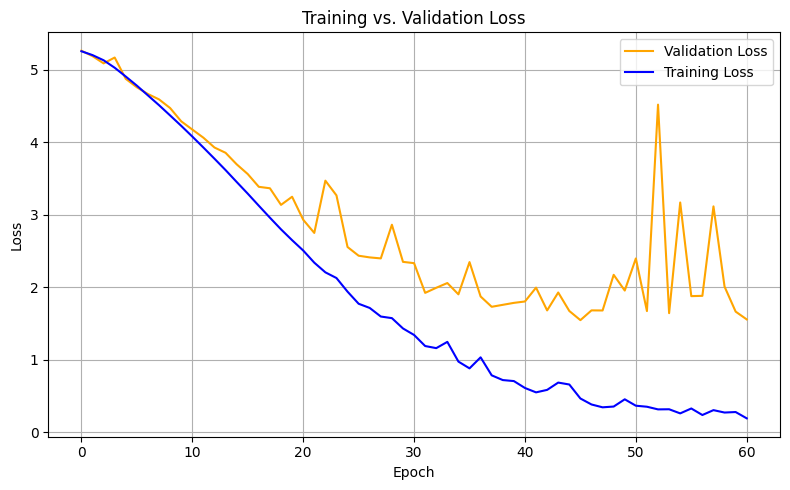

time: 165 ms (started: 2025-04-14 11:07:46 +00:00)


In [ ]:
show_loss(resnet_model2_history)

###Test

####Get Embedding

In [ ]:
test_embeddings_resnet2 = get_embeddings(resnet_model2, X_train)

203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
time: 18.3 s (started: 2025-04-14 11:07:46 +00:00)


####Define Model

In [ ]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(test_embeddings_resnet2, y_train_int)
preds = knn.predict(test_embeddings_resnet2)
acc = accuracy_score(y_train_int, preds)
print(f"KNN Accuracy: {acc:.4f}")

KNN Accuracy: 0.9671
time: 1.04 s (started: 2025-04-14 11:08:04 +00:00)


####Run Test

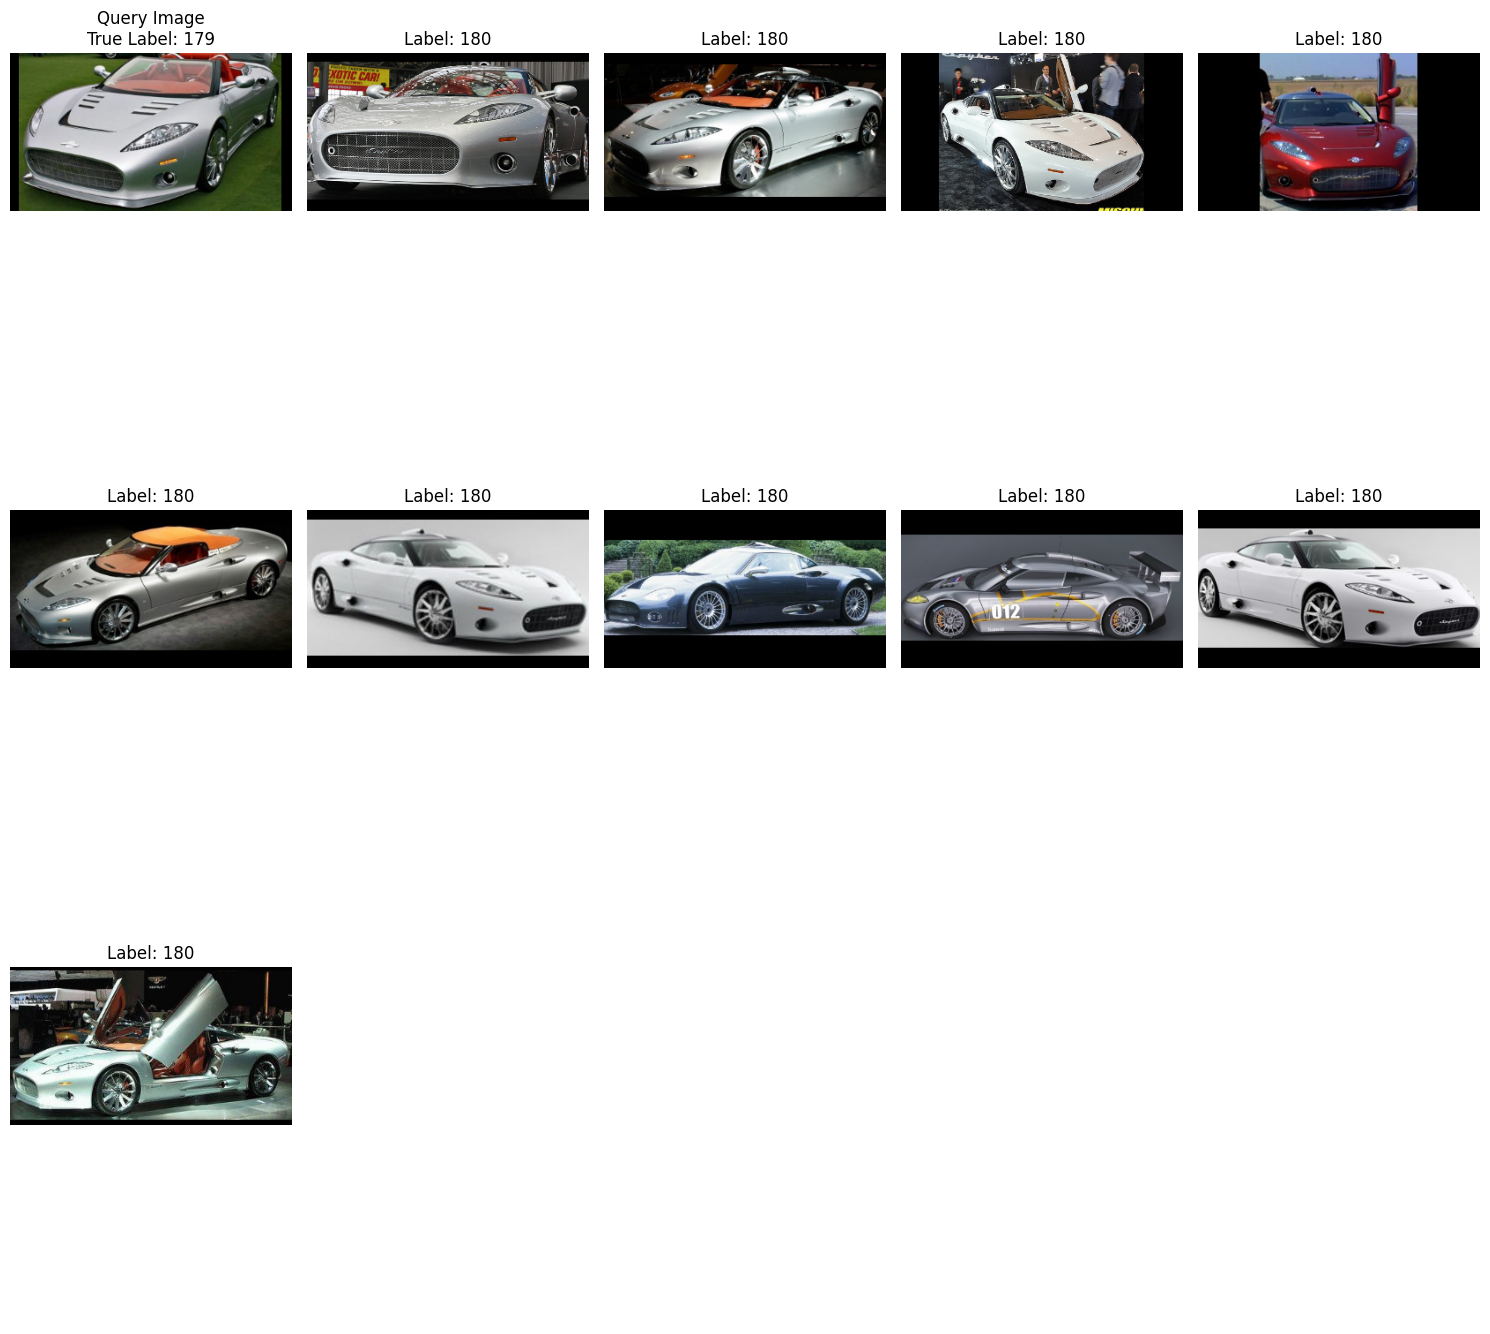

🎯 True label: 179
🔮 Predicted (most common): 180
👥 Nearest labels: [np.int64(180), np.int64(180), np.int64(180), np.int64(180), np.int64(180), np.int64(180), np.int64(180), np.int64(180), np.int64(180), np.int64(180)]
📏 Distances: [0.15042385 0.17321014 0.21263967 0.23902959 0.24657191 0.26089028
 0.26090005 0.26727957 0.27086663 0.27179193]
time: 1.74 s (started: 2025-04-14 11:08:05 +00:00)


In [ ]:
index = 9

nearest_labels, distances, predicted_label = find_nearest_neighbors(
    knn=knn,
    model=resnet_model2,
    query_image=X_test[index],
    y_test_label=y_test_int[index],
    X_train=X_train,
    y_train_labels=y_train_int
)

print(f"🎯 True label: {y_test_int[index]}")
print(f"🔮 Predicted (most common): {predicted_label}")
print(f"👥 Nearest labels: {nearest_labels}")
print(f"📏 Distances: {distances}")

##Resnet Model 3

###Atchitecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class L2Normalization(layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation="relu"):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation(activation)(x)

    return x

def create_resnet_l2_model2(input_shape=(180, 320, 3), embedding_dim=150):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    for filters in [64, 128, 256, 512]:
        for _ in range(3):
            x = residual_block(x, filters)
        x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1000, activation="relu")(x)
    x = layers.Dense(embedding_dim, activation="linear", name="embedding")(x)

    x = L2Normalization(name="l2_normalized")(x)

    model = models.Model(inputs, x, name="resnet_l2_embedding_model")
    return model

resnet_model3 = create_resnet_l2_model2()
resnet_model3.summary()


Model: "resnet_l2_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 90, 160,   │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        256 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 90, 160,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 45, 80,    │          0 │ activation_50[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 45, 80,    │     36,928 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (None, 45, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 45, 80,    │     36,928 │ activation_51[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 45, 80,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_52       │ (None, 45, 80,    │          0 │ add_24[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 45, 80,    │     36,928 │ activation_52[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_53       │ (None, 45, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 45, 80,    │     36,928 │ activation_53[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        256 │ conv2d_60[0][0] 

 Total params: 22,738,542 (86.74 MB)

 Trainable params: 22,725,102 (86.69 MB)

 Non-trainable params: 13,440 (52.50 KB)

time: 504 ms (started: 2025-04-14 11:08:07 +00:00)


###Train

In [ ]:
resnet_model3_train = build_training_model(resnet_model3, num_classes=196)

time: 12.5 ms (started: 2025-04-14 11:08:08 +00:00)


In [ ]:
 resnet_model3_train.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model3_history = resnet_model3_train.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=[early_stopping]
)

Epoch 1/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 66s 83ms/step - accuracy: 0.0072 - loss: 5.2735 - val_accuracy: 0.0099 - val_loss: 5.2482
Epoch 2/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0165 - loss: 5.2234 - val_accuracy: 0.0161 - val_loss: 5.2224
Epoch 3/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0338 - loss: 5.1734 - val_accuracy: 0.0145 - val_loss: 5.2155
Epoch 4/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0518 - loss: 5.1031 - val_accuracy: 0.0584 - val_loss: 5.0560
Epoch 5/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0791 - loss: 5.0102 - val_accuracy: 0.0460 - val_loss: 5.0553
Epoch 6/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.1144 - loss: 4.9049 - val_accuracy: 0.1063 - val_loss: 4.8718
Epoch 7/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.1495 - loss: 4.7962 - val_accuracy: 0.1131 - val_loss: 4.7870
Epoch 8/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.1977 - loss: 4

###Loss Graph

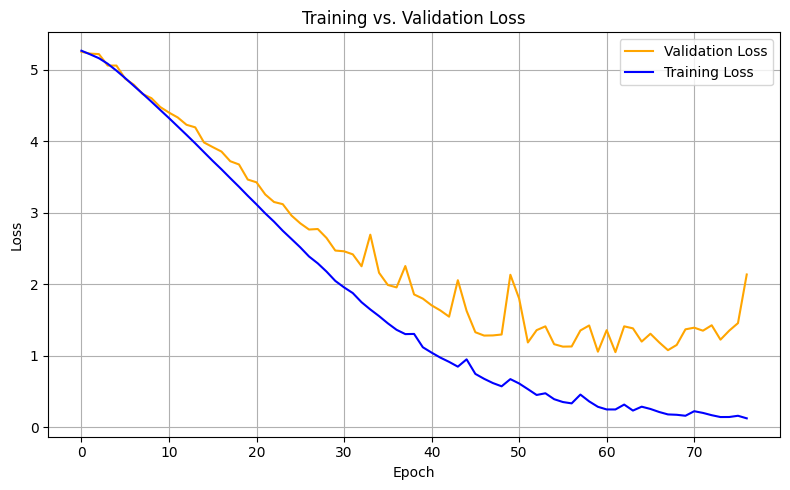

time: 162 ms (started: 2025-04-14 11:26:37 +00:00)


In [ ]:
show_loss(resnet_model3_history)

###Test

####Get Embedding

In [ ]:
test_embeddings_resnet_3 = get_embeddings(resnet_model3, X_train)

203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step
time: 18.7 s (started: 2025-04-14 11:26:37 +00:00)


####Define Model

In [ ]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(test_embeddings_resnet_3, y_train_int)
preds = knn.predict(test_embeddings_resnet_3)
acc = accuracy_score(y_train_int, preds)
print(f"KNN Accuracy: {acc:.4f}")

KNN Accuracy: 0.9924
time: 919 ms (started: 2025-04-14 11:26:56 +00:00)


####Run Test

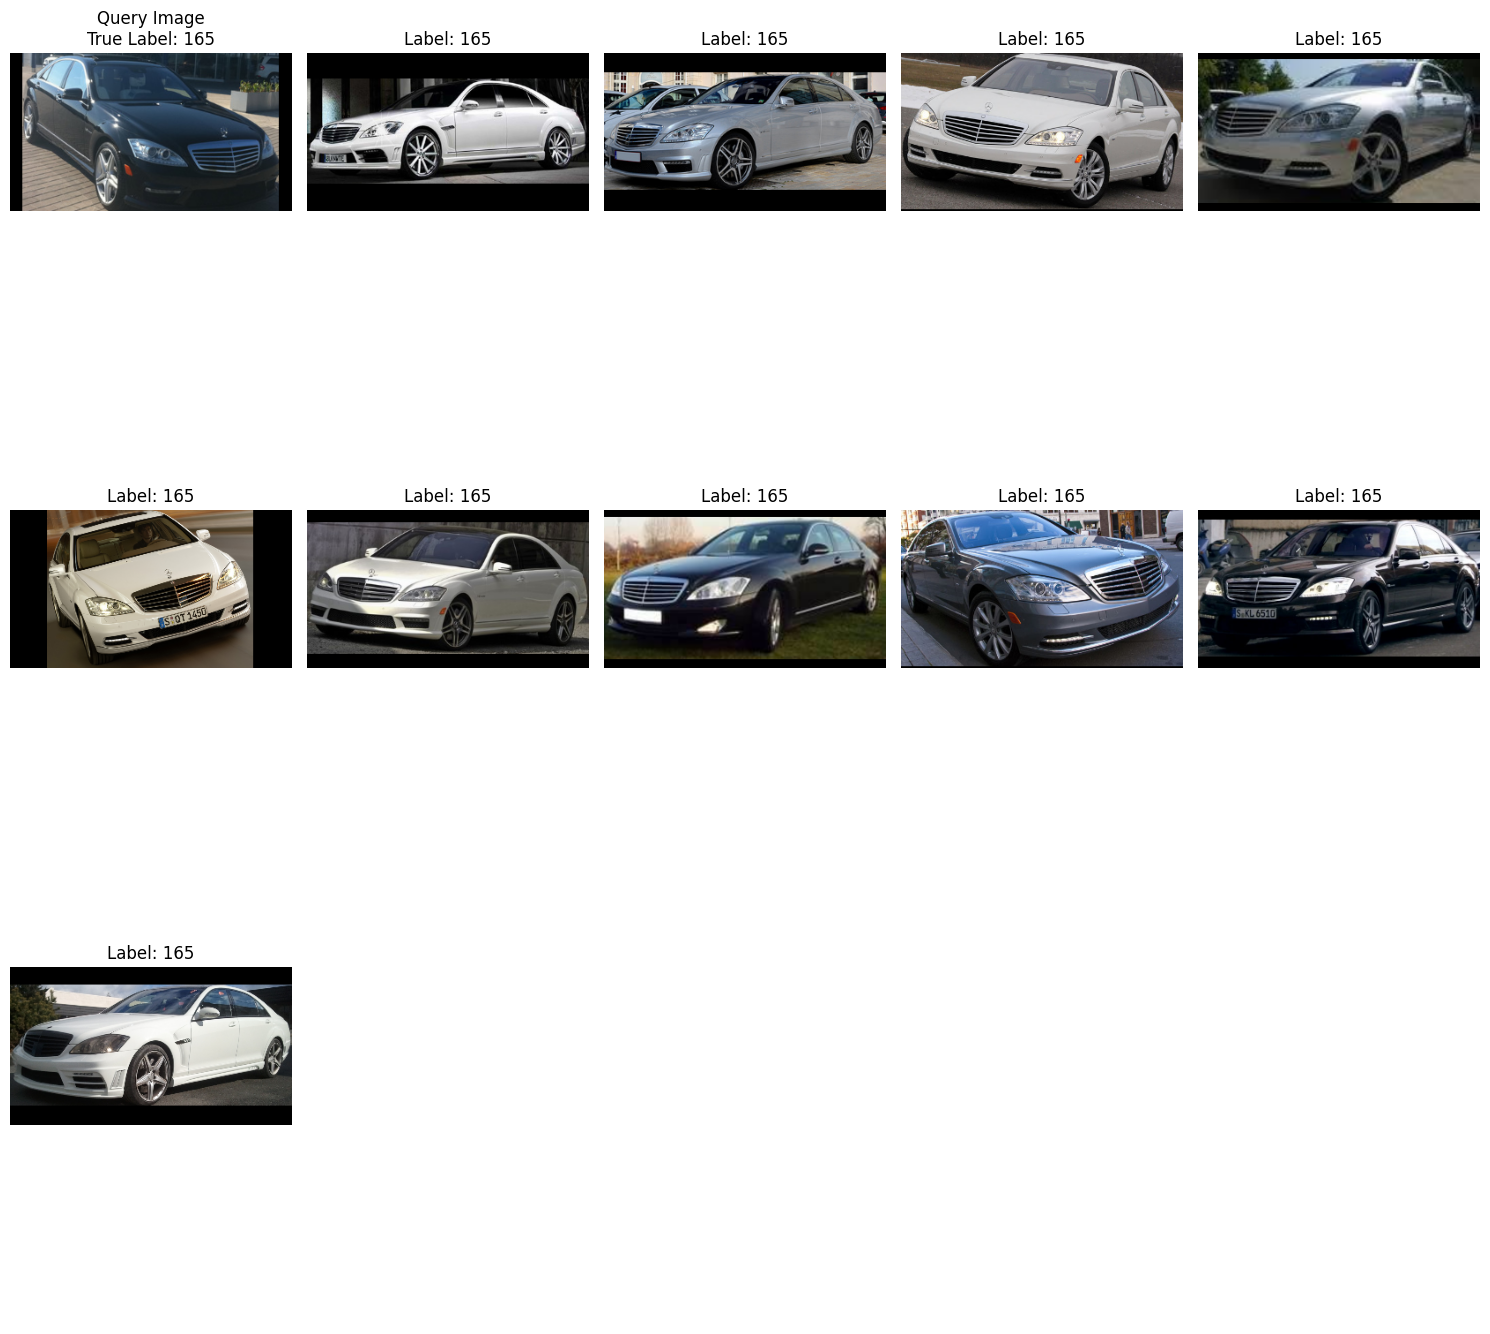

🎯 True label: 165
🔮 Predicted (most common): 165
👥 Nearest labels: [np.int64(165), np.int64(165), np.int64(165), np.int64(165), np.int64(165), np.int64(165), np.int64(165), np.int64(165), np.int64(165), np.int64(165)]
📏 Distances: [0.21188909 0.21685866 0.22322549 0.22500952 0.22755337 0.22800425
 0.22995284 0.23067646 0.2319666  0.23243336]
time: 1.75 s (started: 2025-04-14 11:26:57 +00:00)


In [ ]:
index = 1234

nearest_labels, distances, predicted_label = find_nearest_neighbors(
    knn=knn,
    model=resnet_model3,
    query_image=X_test[index],
    y_test_label=y_test_int[index],
    X_train=X_train,
    y_train_labels=y_train_int
)

print(f"🎯 True label: {y_test_int[index]}")
print(f"🔮 Predicted (most common): {predicted_label}")
print(f"👥 Nearest labels: {nearest_labels}")
print(f"📏 Distances: {distances}")

#Save To Drive

##Save Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
time: 15.7 s (started: 2025-04-14 11:26:59 +00:00)


In [ ]:
save_path = "/content/drive/MyDrive/resnet_model3.keras"
resnet_model3.save(save_path)


time: 5.59 s (started: 2025-04-14 11:27:14 +00:00)


In [ ]:
import joblib

joblib.dump(knn, 'knn_model.pkl')


['knn_model.pkl']

time: 11.2 ms (started: 2025-04-14 11:27:20 +00:00)


In [ ]:
!cp knn_model.pkl /content/drive/MyDrive/


time: 604 ms (started: 2025-04-14 11:27:20 +00:00)


##Save Embedding Vectors

In [ ]:
save_path_embeddings = '/content/drive/MyDrive/resnet_embeddings.npy'
save_path_labels = '/content/drive/MyDrive/resnet_labels.npy'
save_path_train_images = '/content/drive/MyDrive/resnet_train_images.npy'

np.save(save_path_embeddings, test_embeddings_resnet_3)
np.save(save_path_labels, y_train_int)
np.save(save_path_train_images, X_train)

time: 1min 42s (started: 2025-04-14 11:27:21 +00:00)
